Epoch 1/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6082 - loss: 1.8573 - val_accuracy: 0.8784 - val_loss: 0.3650
Epoch 2/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8716 - loss: 0.3807 - val_accuracy: 0.9094 - val_loss: 0.2849
Epoch 3/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9072 - loss: 0.2725 - val_accuracy: 0.9269 - val_loss: 0.2272
Epoch 4/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9179 - loss: 0.2242 - val_accuracy: 0.9289 - val_loss: 0.2078
Epoch 5/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9355 - loss: 0.1872 - val_accuracy: 0.9388 - val_loss: 0.1879
Epoch 6/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9445 - loss: 0.1587 - val_accuracy: 0.9466 - val_loss: 0.1536
Epoch 7/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9496 - loss: 0.1416 - val_accuracy: 0.9468 - val_loss: 0.1515
Epoch 8/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9543 - loss: 0.1310 - val_accu

249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9643 - loss: 0.1222

✅ Test Accuracy: 0.9628
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Classification Report:

                              precision    recall  f1-score   support

         allergy, immunology       1.00      1.00      1.00       205
                  bariatrics       0.98      1.00      0.99       204
   cardiovascular, pulmonary       0.94      0.96      0.95       204
                chiropractic       0.96      1.00      0.98       204
       consult, history, phy       1.00      0.98      0.99       204
  cosmetic, plastic, surgery       0.97      1.00      0.99       204
                   dentistry       0.94      0.95      0.94       204
                 dermatology       1.00      1.00      1.00       204
           diets, nutritions       1.00      1.00      1.00       204
          discharge, summary       1.00      0.99      0.99       204
    emergency, room, reports       0.95      0.97      0.96  

C:\Users\BADR\AppData\Local\Temp\ipykernel_13368\2914202376.py:113: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\BADR\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


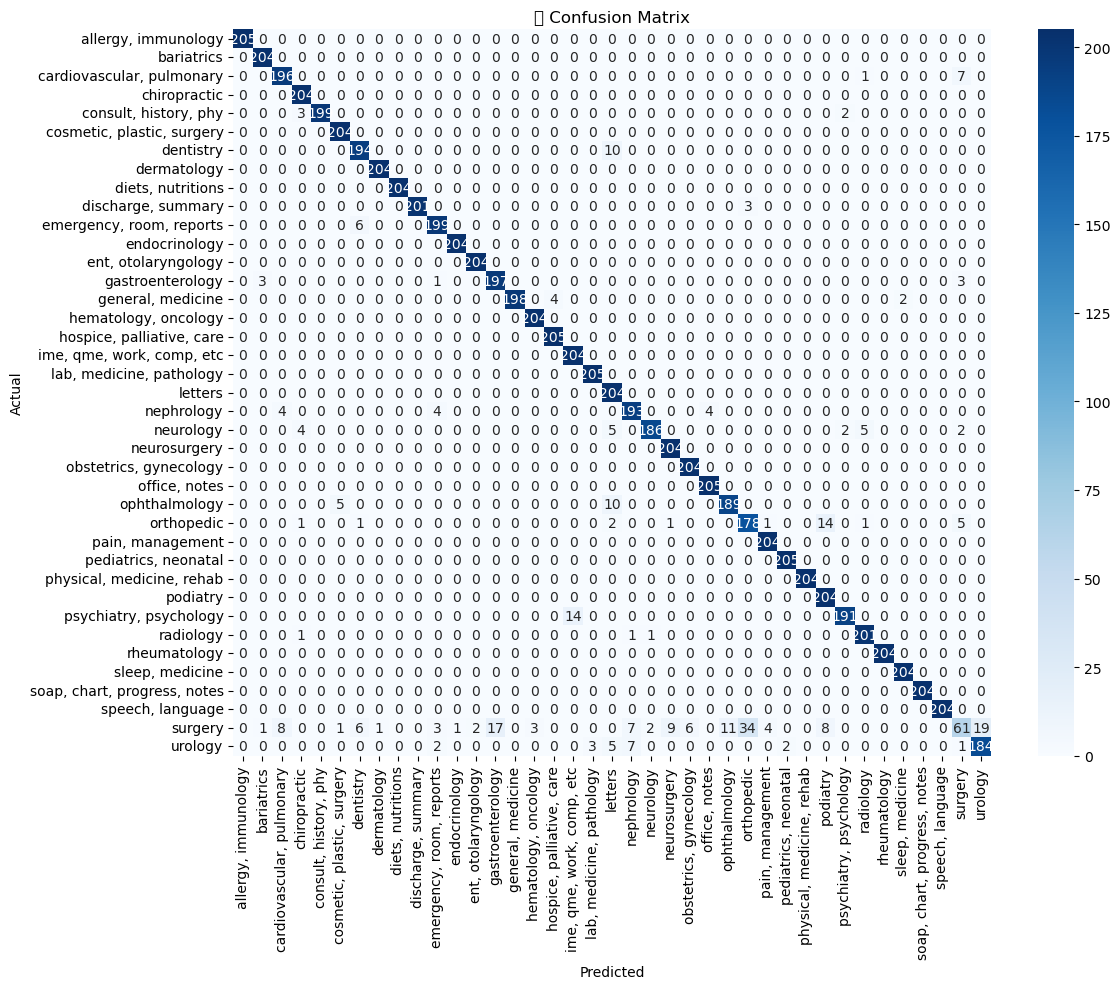


🔁 Prediction Test #1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

🩺 Predicted Specialty: cardiovascular, pulmonary
🔮 Confidence: 0.9745

🔁 Prediction Test #2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

🩺 Predicted Specialty: gastroenterology
🔮 Confidence: 0.9040

🔁 Prediction Test #3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

🩺 Predicted Specialty: office, notes
🔮 Confidence: 0.5568

🔁 Prediction Test #4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

🩺 Predicted Specialty: dermatology
🔮 Confidence: 0.2212


In [5]:
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import RandomOverSampler
import joblib
import os
import re

# Load dataset
df = pd.read_csv("data_zwina.csv")

# Preprocess columns
df['keywords'] = df['keywords'].apply(lambda x: ' '.join(ast.literal_eval(x)) if isinstance(x, str) else '')
df['transcription'] = df['transcription'].astype(str)
df['description'] = df['description'].astype(str)
df['sample_name'] = df['sample_name'].astype(str)
df['medical_specialty'] = df['medical_specialty'].astype(str)

# Combine all text fields
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

df['all_text'] = (
    df['description'] + ' ' +
    df['sample_name'] + ' ' +
    df['keywords'] + ' ' +
    df['transcription']
).apply(preprocess_text)

# Vectorize text
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(df['all_text']).toarray()

# Encode target labels
specialties = sorted(df['medical_specialty'].unique())
specialty_to_index = {name: i for i, name in enumerate(specialties)}
index_to_specialty = {i: name for name, i in specialty_to_index.items()}
y = df['medical_specialty'].map(specialty_to_index).values
y_cat = to_categorical(y, num_classes=len(specialties))

# Oversample
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y_cat)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

# Build model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(specialties), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop]
)

# Save model and vectorizer
model.save("medical_specialty_model.h5")
joblib.dump(vectorizer, "vectorizer.pkl")

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {accuracy:.4f}")

# Predict on test set
y_test_labels = np.argmax(y_test, axis=1)
y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Classification report
report = classification_report(y_test_labels, y_pred_labels, target_names=specialties)
print("\n📊 Classification Report:\n")
print(report)

# Confusion matrix
conf_mat = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_mat, xticklabels=specialties, yticklabels=specialties, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("🧾 Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Prediction function
def predict_specialty(text_input):
    if not hasattr(predict_specialty, "model"):
        predict_specialty.model = load_model("medical_specialty_model.h5")
        predict_specialty.vectorizer = joblib.load("vectorizer.pkl")

    processed_text = preprocess_text(text_input)
    processed_vector = predict_specialty.vectorizer.transform([processed_text]).toarray()
    prediction = predict_specialty.model.predict(processed_vector)
    predicted_index = np.argmax(prediction)
    predicted_specialty = index_to_specialty[predicted_index]
    confidence = prediction[0][predicted_index]

    print(f"\n🩺 Predicted Specialty: {predicted_specialty}")
    print(f"🔮 Confidence: {confidence:.4f}")
    return predicted_specialty, confidence

# Test sample
sample_texts = [
    "Follow-up for chronic obstructive pulmonary disease. Persistent cough and wheezing.",
    "The patient underwent colonoscopy due to abdominal pain and irregular bowel movements.",
    "Atypical chest pain and shortness of breath noted during exertion.",
    "Red itchy rash on forearms and neck with no signs of infection."
]

for i, text in enumerate(sample_texts, 1):
    print(f"\n🔁 Prediction Test #{i}")
    predict_specialty(text)


In [14]:
model.save("medical_specialty_model.h5")
joblib.dump(vectorizer, "vectorizer.pkl")


['vectorizer.pkl']

In [13]:
sample_texts = [
    "A 50-year-old female whose 51-year-old sister has a history of multiple colon polyps, which may slightly increase her risk for colon cancer in the future."
]

for i, text in enumerate(sample_texts, 1):
    print(f"\n🔁 Prediction Test #{i}")
    predict_specialty(text)



🔁 Prediction Test #1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

🩺 Predicted Specialty: gastroenterology
🔮 Confidence: 0.6822


In [ ]:
model.save("medical_specialty_model.keras")
joblib.dump(vectorizer, "vectorizer.pkl")
joblib.dump(index_to_specialty, "index_to_specialty.pkl")


['index_to_specialty.pkl']

In [20]:
# Save trained model in modern Keras format
model.save("medical_specialty_model.keras")

# Save the trained TF-IDF vectorizer
joblib.dump(vectorizer, "vectorizer.pkl")

# Save the label index-to-specialty mapping
joblib.dump(index_to_specialty, "index_to_specialty.pkl")


['index_to_specialty.pkl']